In [1]:
import ee
import numpy as np
from osgeo import gdal
from osgeo import osr
import time
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import pandas as pd
import seaborn as sns
from scipy import stats
import folium

# init the ee object
ee.Initialize()

In [2]:
# https://www.techforwildlife.com/blog/2019/1/22/analysing-drone-and-satellite-imagery-using-vegetation-indices
def p2r(point, area_size = 500):
    dist_lat = abs(area_size / 110.540)/1000
    dist_lon = abs(area_size / (111.320 * np.cos(point[0])))/1000
    area = {"type": "FeatureCollection", "features": [{"type": "Feature", "properties": {},"geometry": {"type": "Polygon", "coordinates": [[[point[0] - dist_lon/2, point[1] - dist_lat/2], [point[0] + dist_lon/2, point[1] - dist_lat/2], [point[0] + dist_lon/2, point[1] + dist_lat/2], [point[0] - dist_lon/2, point[1] + dist_lat/2], [point[0] - dist_lon/2, point[1] - dist_lat/2]]]}}]}
    coords_area = area['features'][0]['geometry']['coordinates']
    aoi_area = ee.Geometry.Polygon(coords_area)
    return area, aoi_area

def NDVI(img):
    ndvi = ee.Image(img.normalizedDifference(['B8', 'B4'])).rename(["ndvi"])
    return ndvi

def NDWI(img):
    ndwi = ee.Image(img.normalizedDifference(['B3', 'B8'])).rename(["ndwi"])
    return ndwi

def NDII(img):
    ndii = ee.Image(img.normalizedDifference(['B8', 'B11'])).rename(["ndii"])
    return ndii

def sNDVI(img):
    sndvi = ee.Image(img.normalizedDifference(['B3', 'B4'])).rename(["sndvi"])
    return sndvi

def VDVI(img):
    vdvi = img.expression(
        '((2 * GREEN) - RED - BLUE) / ( (2 * GREEN) + RED + BLUE)', {
          'GREEN': img.select('B3'),
          'RED': img.select('B4'),
          'BLUE': img.select('B2')})
    return vdvi

def TDVI(img):
    tdvi = img.expression(
        '1.5 * (NIR - RED) / sqrt(NIR ** 2 + RED + 0.5)', {
          'NIR': img.select('B8'),
          'RED': img.select('B4')})
    return tdvi

def ExGI(img):
    exgi = img.expression(
        '2 * GREEN - (RED + BLUE)', {
          'GREEN': img.select('B3'),
          'RED': img.select('B4'),
          'BLUE': img.select('B2')})
    return exgi

def GCC(img):
    gcc = img.expression(
        'GREEN / (RED + GREEN + BLUE)', {
          'GREEN': img.select('B3'),
          'RED': img.select('B4'),
          'BLUE': img.select('B2')})
    return gcc

def EVI(img):
    evi = img.expression(
        '2.5 * ((NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1))', {
          'NIR': img.select('B8'),
          'RED': img.select('B4'),
          'BLUE': img.select('B2')})
    return evi

def EVI2(img):
    evi2 = img.expression(
        '2.5 * ((NIR - RED) / (NIR + 2.4 * RED + 1))', {
          'NIR': img.select('B8'),
          'RED': img.select('B4')})
    return evi2

def RVI(img):
    rvi = img.expression(
        'RED/NIR', {
          'NIR': img.select('B8'),
          'RED': img.select('B4')})
    return rvi

def ARVI(img):
    arvi = img.expression(
        '(NIR-RED * BLUE) / (NIR+RED * BLUE)', {
          'NIR': img.select('B8'),
          'RED': img.select('B4'),
          'BLUE': img.select('B2')})
    return arvi

def GARI(img):
    gari = img.expression(
        '(NIR–(GREEN – (1.70 * (BLUE – RED)))) / (NIR + (GREEN – (1.70 * (BLUE – RED))))', {
          'NIR': img.select('B8'),
          'RED': img.select('B4'),
          'GREEN': img.select('B3'),
          'BLUE': img.select('B2')})
    return gari

def VARI(img):
    vari = img.expression(
        '(GREEN - RED) / (GREEN + RED - BLUE)', {
          'RED': img.select('B4'),
          'GREEN': img.select('B3'),
          'BLUE': img.select('B2')})
    return vari

def DVI(img):
    dvi = img.expression(
        'NIR - RED', {
          'NIR': img.select('B8'),
          'RED': img.select('B4')})
    return dvi

def MSAVI2(img):
    msavi2 = img.expression(
        '(2 * NIR + 1 - (((2 * NIR + 1) ** 2 - 8 * (NIR - RED)) ** 0.5)) / 2', {
          'NIR': img.select('B8'),
          'RED': img.select('B4')})
    return msavi2

def SAVI(img):
    savi = img.expression(
        '((NIR - RED) / (NIR + RED + 0.5)) * 1.5', {
          'NIR': img.select('B8'),
          'RED': img.select('B4')})
    return savi

def LAI(img):
    lai = img.expression(
        '-log10((0.69 - ((NIR - RED) / (NIR + RED + 0.5)) * 1.5) / 0.59) / 0.91', {
          'NIR': img.select('B8'),
          'RED': img.select('B4')})
    return lai

def MCARI(img):
    mcari = img.expression(
        '(REDEDGE - RED) - 0.2 * (REDEDGE - GREEN) * (REDEDGE / RED)', {
          'RED': img.select('B4'),
          'GREEN': img.select('B3'),
          'REDEDGE': img.select('B5')})
    return mcari

def SIPI(img):
    sipi = img.expression(
        '(B8 - B1) / (B8 - B4) ', {
          'B1': img.select('B1'),
          'B4': img.select('B4'),
          'B8': img.select('B8')})
    return sipi

def GLI(img):
    gli = img.expression(
        '((GREEN - RED) + (GREEN - BLUE)) / ((2 * GREEN) + (BLUE + RED))', {
          'RED': img.select('B4'),
          'GREEN': img.select('B3'),
          'BLUE': img.select('B2')})
    return gli

def LCI(img):
    lci = img.expression(
        '(NIR - REDEDGE) / (NIR + RED)', {
          'RED': img.select('B4'),
          'NIR': img.select('B8'),
          'REDEDGE': img.select('B5')})
    return lci

def OSAVI(img):
    osavi = img.expression(
        '((NIR - RED) / (NIR + RED + 0.16))', {
          'NIR': img.select('B8'),
          'RED': img.select('B4')})
    return osavi


def SATVI(img):
    satvi = img.expression(
        '((SWIR1 - RED) / (SWIR1 + RED + 0.5) * (1 + 0.5) - SWIR2 / 2)', {
          'RED': img.select('B4'),
          'SWIR1': img.select('B11'),
          'SWIR2': img.select('B12')})
    return satvi

def AVI(img):
    avi = img.expression(
        '((B4 + 1) * (256 - B3) * (B4 - B3)) ** (1 / 3)', {
          'B3': img.select('B3'),
          'B4': img.select('B4')})
    return avi

def BI(img):
    bi = img.expression(
        '((B4 + B2) - B3) / ((B4 + B2) + B3)', {
          'B3': img.select('B3'),
          'B4': img.select('B4'),
          'B2': img.select('B2')})
    return bi

def SI(img):
    si = img.expression(
        'sqrt((256 - B2) * (256 - B3))', {
          'B2': img.select('B2'),
          'B3': img.select('B3')})
    return si

def LatLonImg(img):
    img = img.addBands(ee.Image.pixelLonLat())
    img = img.reduceRegion(reducer=ee.Reducer.toList(),\
                                        geometry=area,\
                                        maxPixels=1e13,\
                                        scale=10);
 
    data = np.array((ee.Array(img.get("result")).getInfo()))
    lats = np.array((ee.Array(img.get("latitude")).getInfo()))
    lons = np.array((ee.Array(img.get("longitude")).getInfo()))
    return lats, lons, data

def toImage(lats,lons,data):
    uniqueLats = np.unique(lats)
    uniqueLons = np.unique(lons)
    ncols = len(uniqueLons)
    nrows = len(uniqueLats)
    ys = uniqueLats[1] - uniqueLats[0]
    xs = uniqueLons[1] - uniqueLons[0]
    arr = np.zeros([nrows, ncols], np.float32) #-9999
    counter =0
    for y in range(0,len(arr),1):
        for x in range(0,len(arr[0]),1):
            if lats[counter] == uniqueLats[y] and lons[counter] == uniqueLons[x] and counter < len(lats)-1:
                counter+=1
                arr[len(uniqueLats)-1-y,x] = data[counter] # we start from lower left corner
    return arr

def format_xtick_labels(x, pos): return '{0:.3f}$^\circ$N'.format(x)
def format_ytick_labels(x, pos): return '{0:.3f}$^\circ$E'.format(x)

def VegInt(area, date_start, date_end, ind):
    
    try:
        # define the image
        collection = ee.ImageCollection("COPERNICUS/S2").filterBounds(area)\
                                              .filterDate(date_start, date_end)\

        print(" number of image: ",collection.size().getInfo())
        acq_times = collection.aggregate_array('system:time_start').getInfo()

        im_list = collection.toList(collection.size())

        dates = [time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times]
        myCollection = collection.map(ind)
        result = ee.Image(myCollection.median()).rename(['result'])
        lat, lon, data = LatLonImg(result)
        image  = toImage(lat,lon,data)
        title = str(ind).split(' ')[1]
        if ind == NDVI:
            cmap = 'RdYlGn'; vmax = -1; vmin = 1
        elif ind == NDWI:
            cmap = 'coolwarm_r'; vmax = 1; vmin = -1
        else:
            cmap = 'BrBG'; vmax = 1; vmin = -1
        
        # in case you want to plot the image
        plt.gcf().set_size_inches(15, 6)
        plt.subplot(1, 2, 1)
        plt.title(title, fontsize = 20)
        plt.imshow(image, cmap=cmap, extent = (lat.min(), lat.max(), lon.min(), lon.max()), vmax = vmax, vmin = vmin)
        plt.colorbar()
        
        plt.xticks(rotation=90)
        plt.gca().xaxis.set_major_formatter(FuncFormatter(format_xtick_labels))
        plt.gca().yaxis.set_major_formatter(FuncFormatter(format_ytick_labels))
        plt.grid(color = "#808080", ls = ":")

        plt.subplot(1, 2, 2)
        plt.hist(image[3], bins = 25, histtype='stepfilled', density=True, fc='#CCCCCC')
        plt.hist(image[3], bins = 25, histtype='step', density=True, color='black')
        kdeline = sns.kdeplot(np.array(image[3]), color = 'r', ls = '--')
        xs = kdeline.lines[0].get_xdata()
        ys = kdeline.lines[0].get_ydata()    
        plt.vlines(np.median(np.array(image[3])), 0, np.interp(np.median(image[3]), xs, ys), color = 'navy', zorder = 9)
        plt.title('The median value of the parameter {} = {:.3f}'.format(title, np.median(image[3])))
        plt.show();
    except:
        image = np.zeros(100).reshape((10, 10))
        pass
    return(image)

In [3]:
station = [40.54, 22.99]

map = folium.Map(location=station, zoom_start=15)

basemaps = {
        'Google Satellite Hybrid': folium.TileLayer(
            tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
            attr = 'Google',
            name = 'Google Satellite',
            overlay = True,
            control = True
        )
    }
folium.LatLngPopup().add_to(map)
basemaps['Google Satellite Hybrid'].add_to(map)
map

 number of image:  4


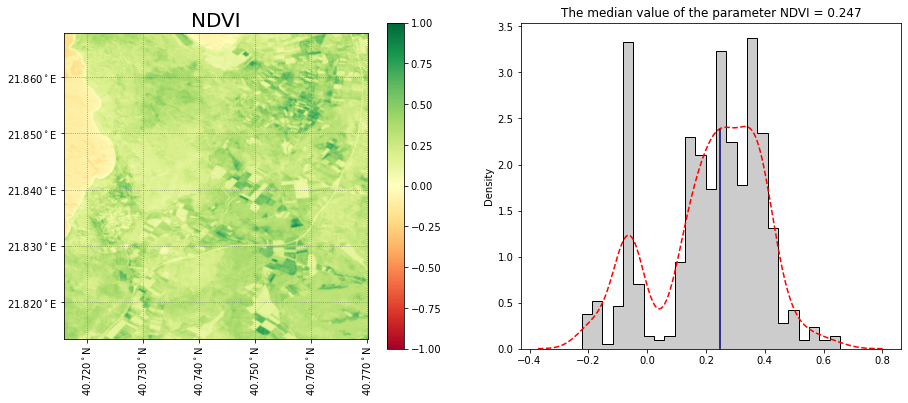

 number of image:  4


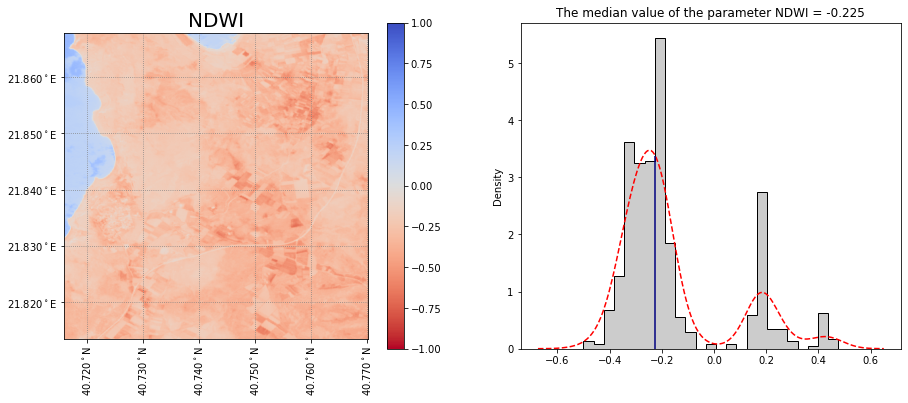

 number of image:  4


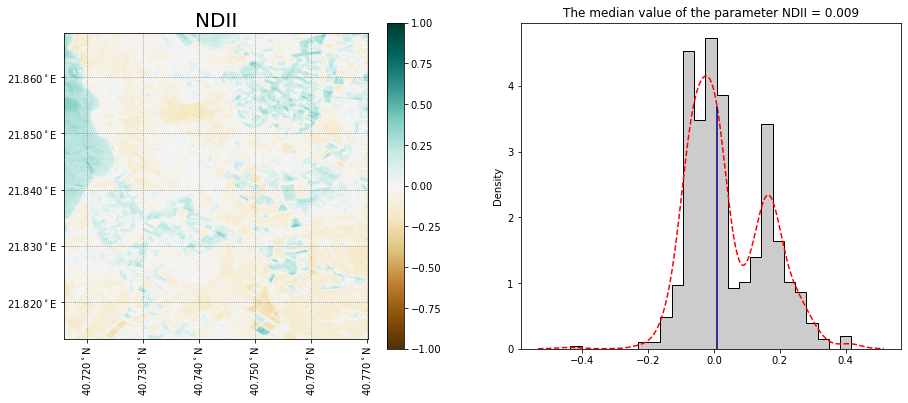

 number of image:  4


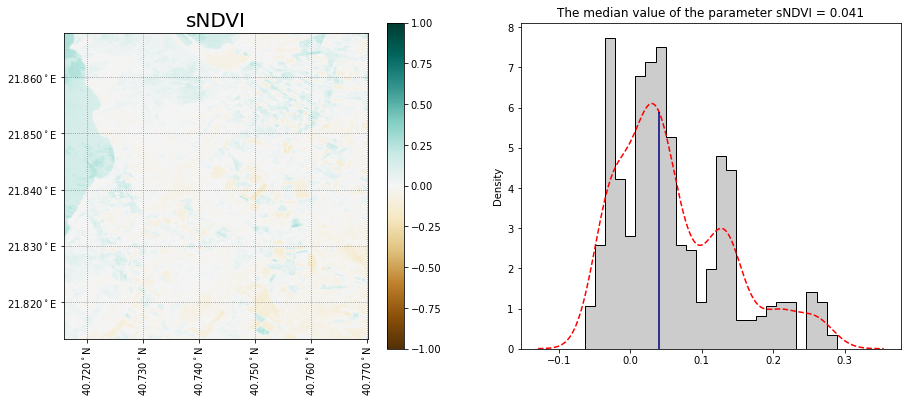

 number of image:  4


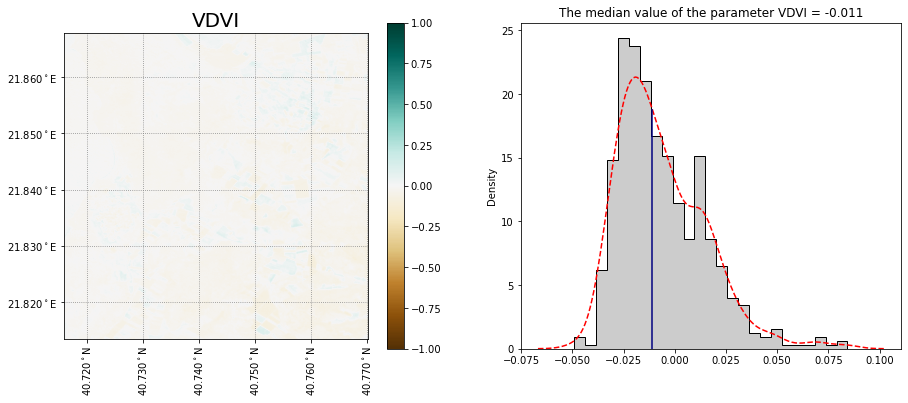

 number of image:  4


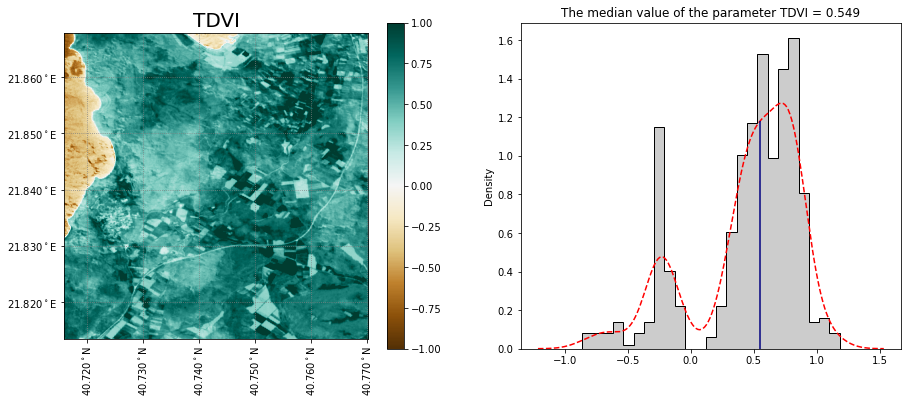

 number of image:  4


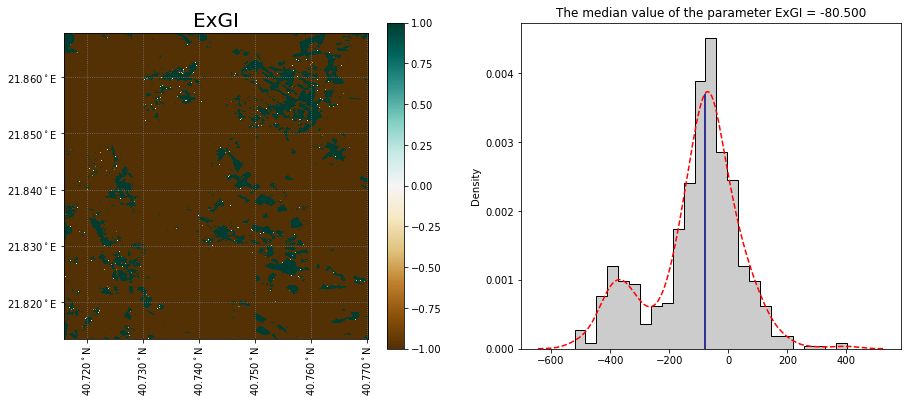

 number of image:  4


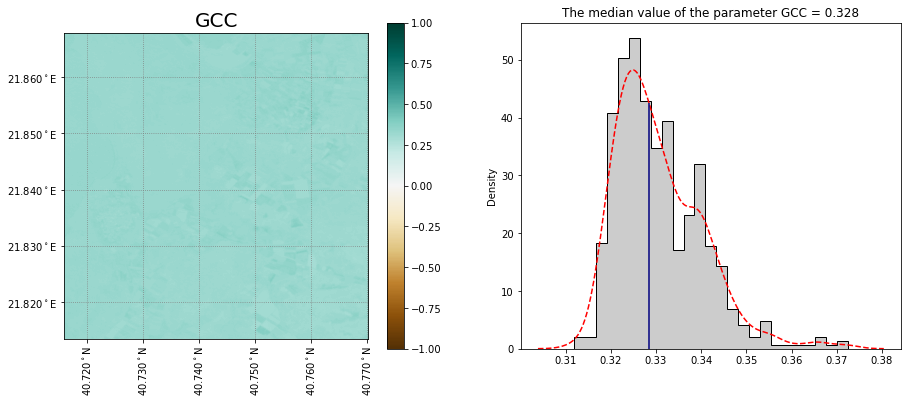

 number of image:  4


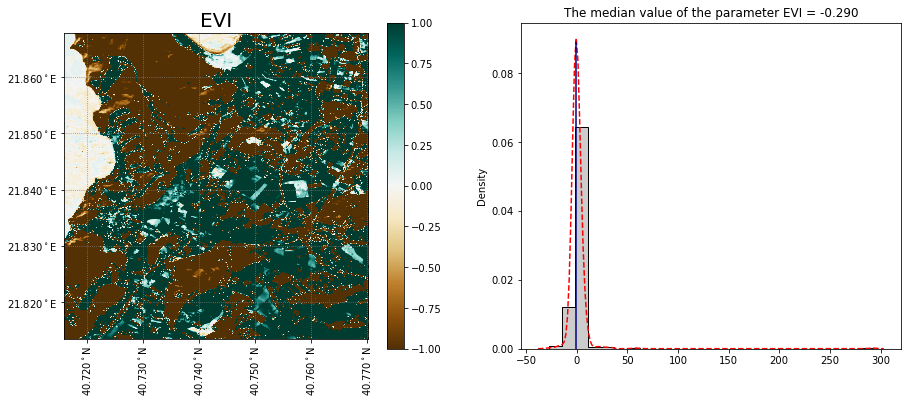

 number of image:  4


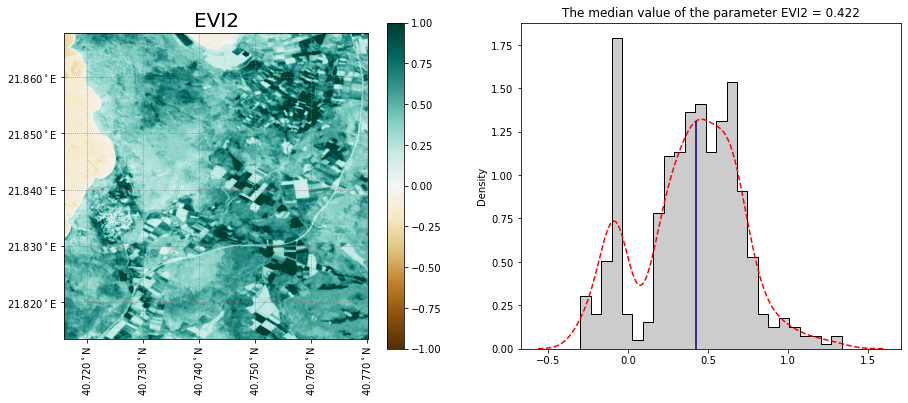

 number of image:  4


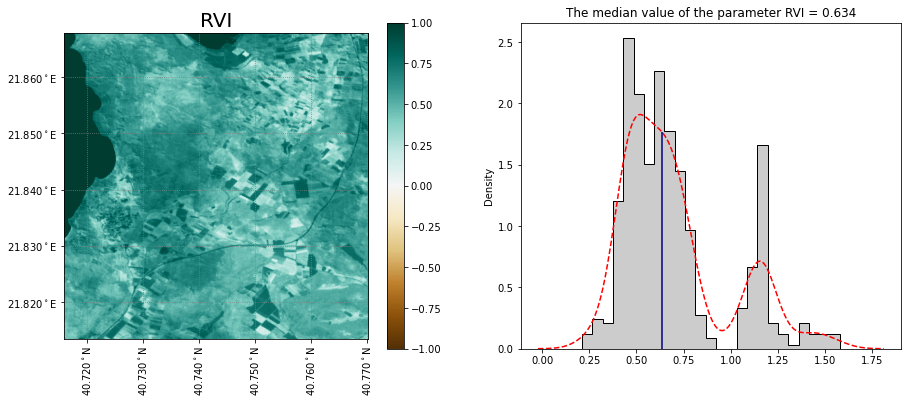

 number of image:  4


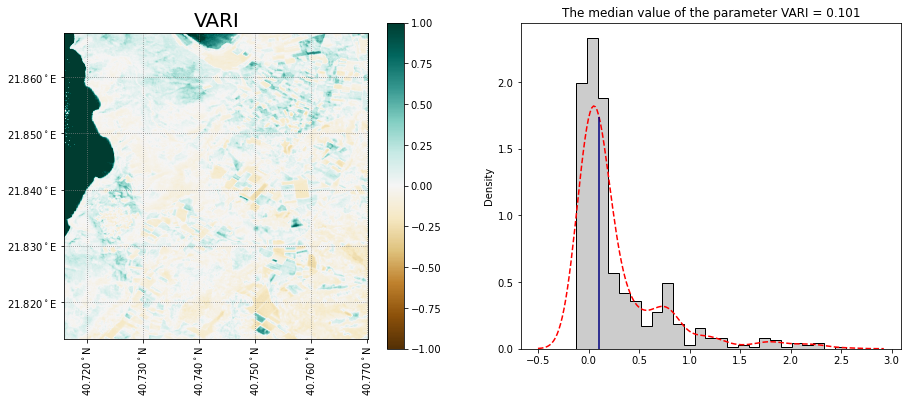

 number of image:  4


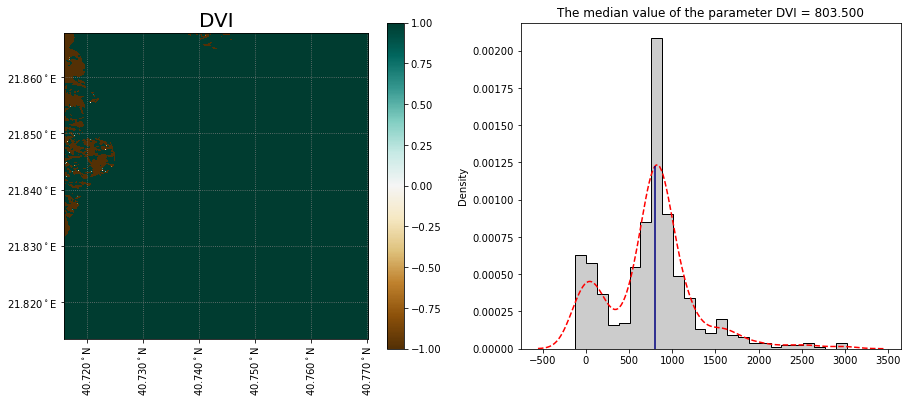

 number of image:  4


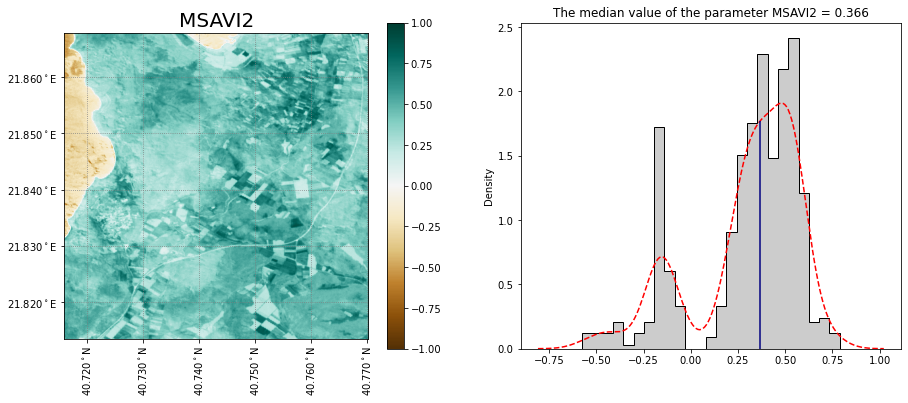

 number of image:  4


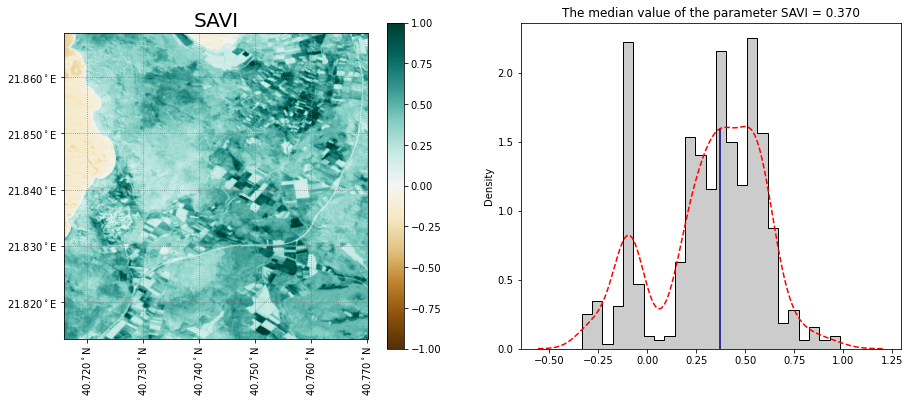

 number of image:  4


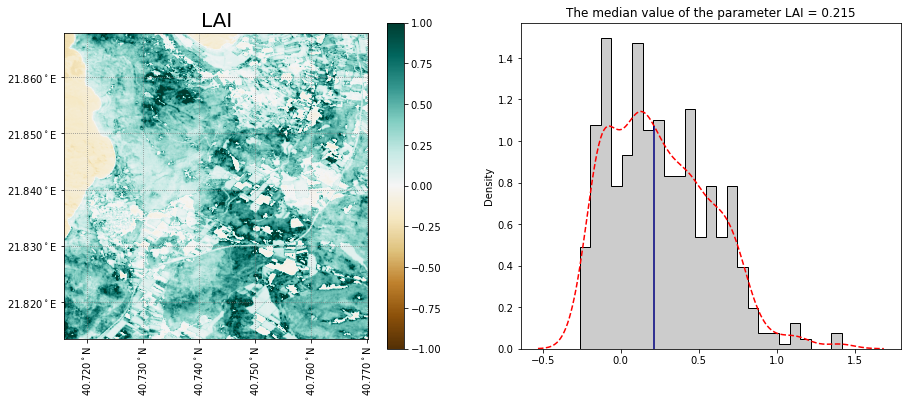

 number of image:  4


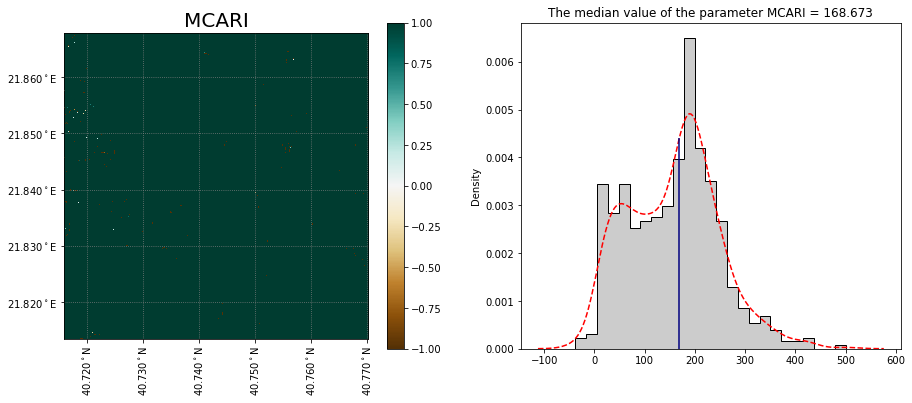

 number of image:  4


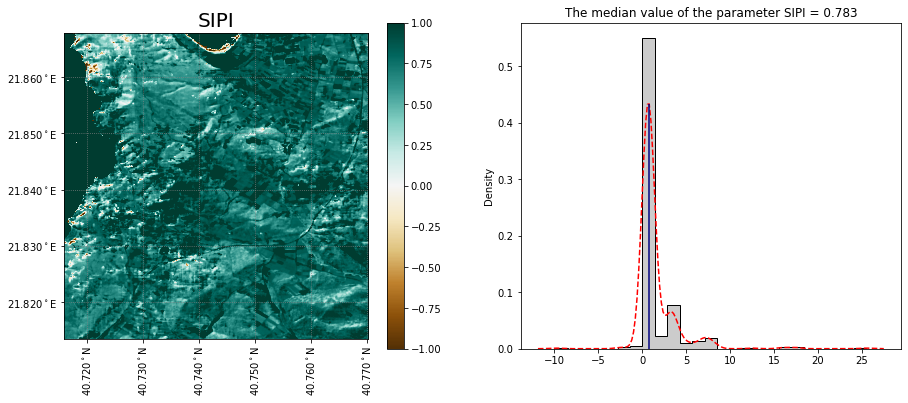

 number of image:  4


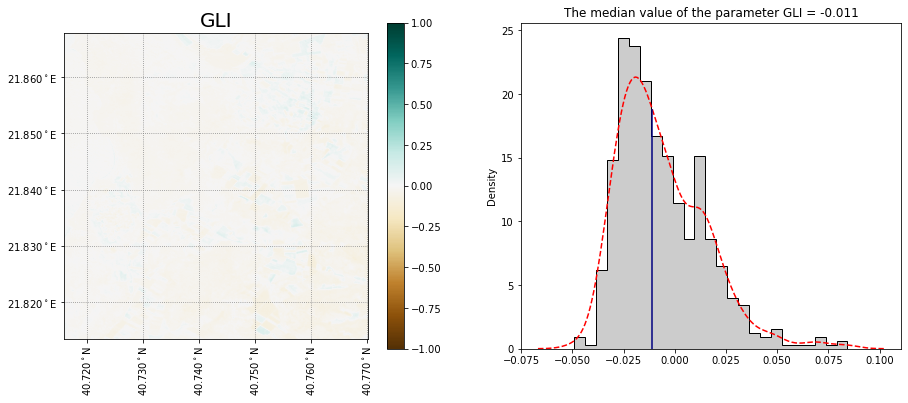

 number of image:  4


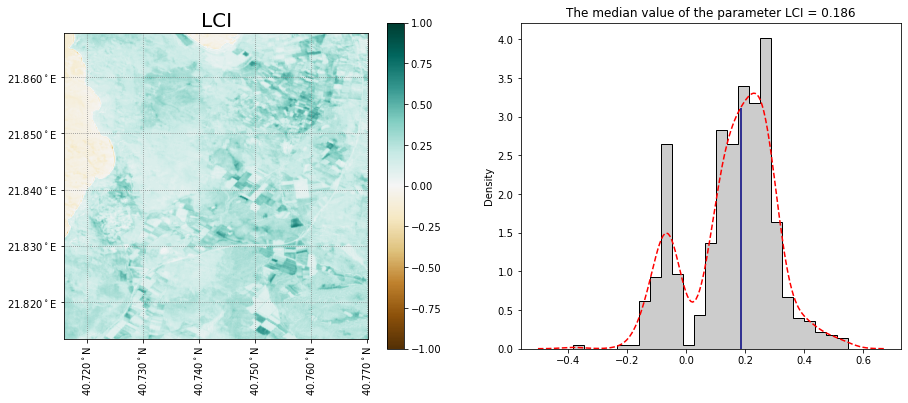

 number of image:  4


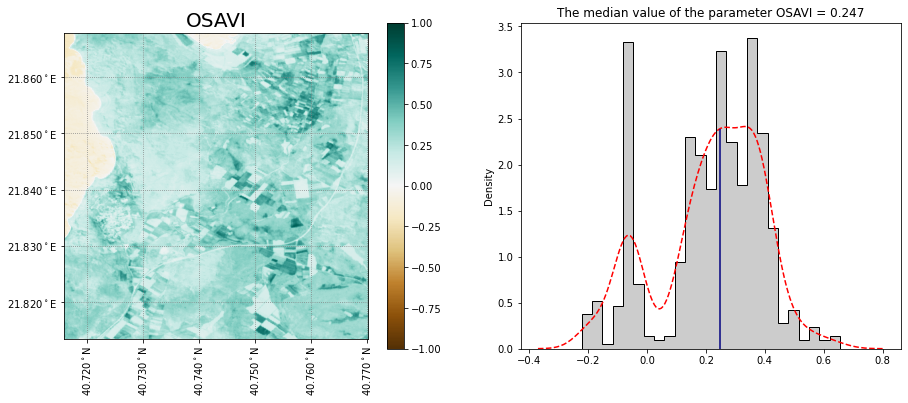

 number of image:  4


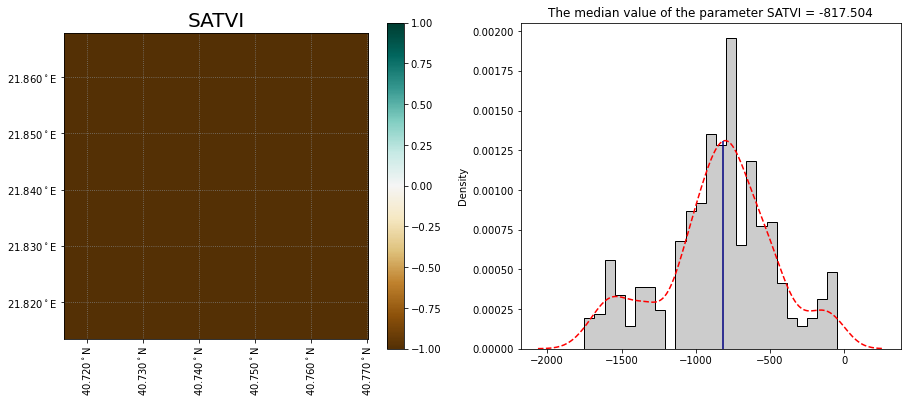

 number of image:  4


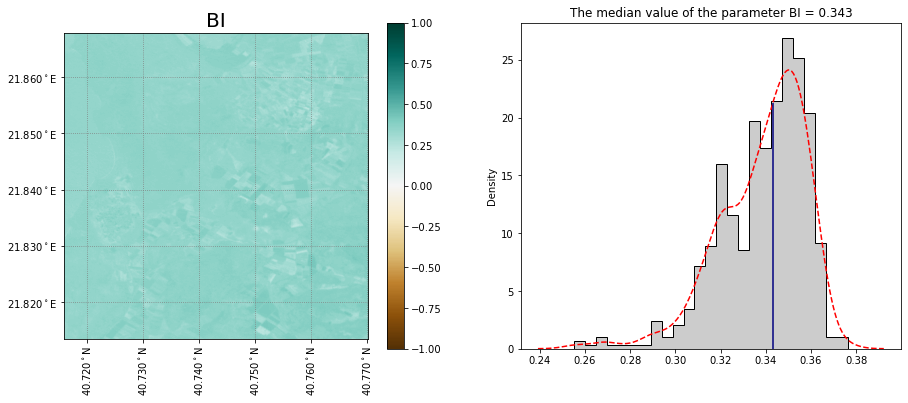

 number of image:  4


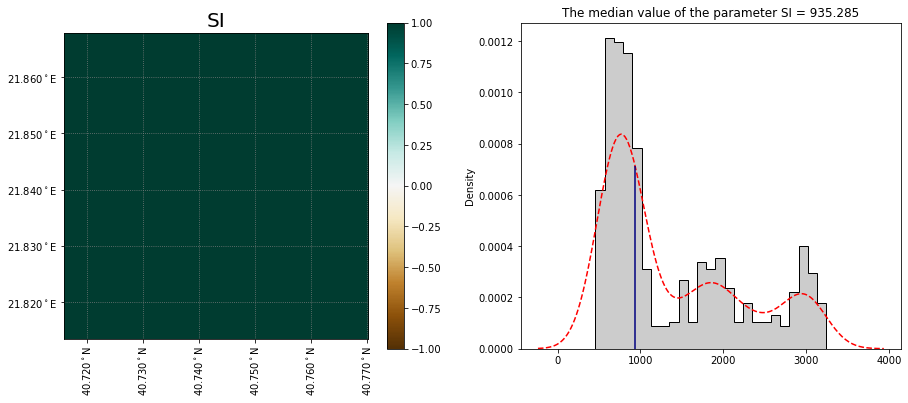

In [33]:
# inds = {1: NDVI, 2: NDWI, 3: EVI, 4: EVI2, 5: RVI, 6: MSAVI2, 7: SAVI, 8: OSAVI, 9: SATVI, 10: AVI, 11: BI, 12: SI, 13: LAI}
inds = [NDVI, NDWI, NDII, sNDVI, VDVI, TDVI, ExGI, GCC, EVI, EVI2, RVI, ARVI, GARI, VARI, DVI, MSAVI2, SAVI, LAI, MCARI, SIPI, GLI, LCI, OSAVI, SATVI, AVI, BI, SI]
inds = [NDVI, NDWI, NDII, sNDVI, VDVI, TDVI, ExGI, GCC, EVI, EVI2, RVI, VARI, DVI, MSAVI2, SAVI, LAI, MCARI, SIPI, GLI, LCI, OSAVI, SATVI, BI, SI]
# inds = [NDVI, NDWI]
areaJson, area = p2r([21.8407, 40.7431], area_size = 6000)
date_start, date_end = "2018-01-01","2019-01-01"
date_start, date_end = "2018-04-01","2018-04-12"

for i in inds:
    VegInt(area, date_start, date_end, i)

 number of image:  1


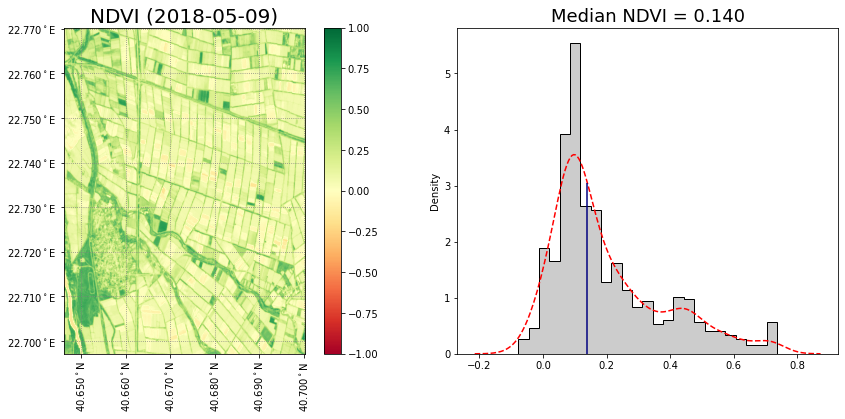

 number of image:  1


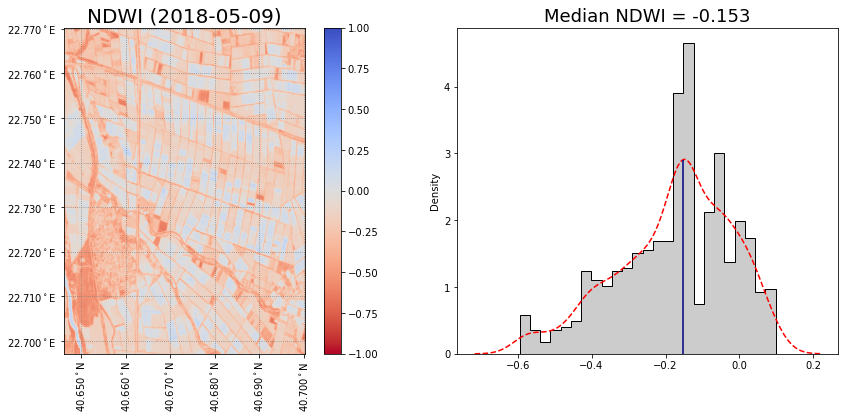

In [37]:
inds = [NDVI, NDWI]

areaJson, area = p2r([22.7337, 40.6732], area_size = 6000)
date_start, date_end = '2018-05-09','2018-05-12'

for i in inds:
    VegInt(area, date_start, date_end, i)
#     plt.savefig('{}_2.jpg'.format(str(i)[10:-23]), format='jpg', dpi=1200, bbox_inches='tight')
#     plt.show();

 number of image:  1


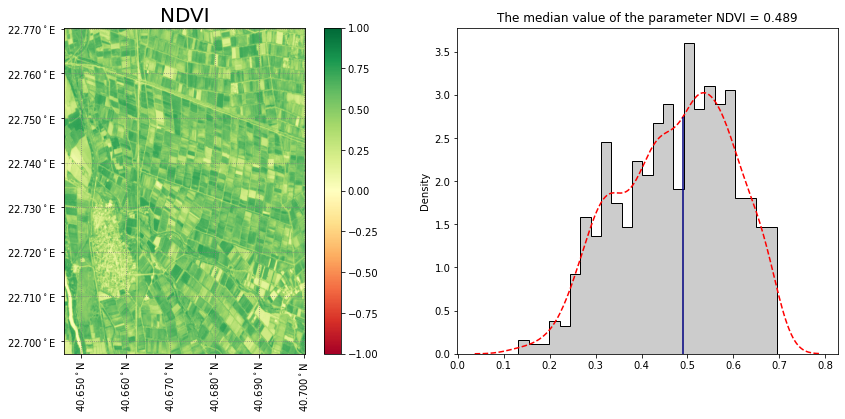

In [8]:
inds = [NDVI]
areaJson, area = p2r([22.7337, 40.6732], area_size = 6000)
date_start, date_end = '2018-06-08','2018-06-12'

for i in inds:
    VegInt(area, date_start, date_end, i)
#     plt.savefig('{}_1.jpg'.format(str(i)[10:-23]), format='jpg', dpi=1200, bbox_inches='tight')
    plt.show();